Found 902 images belonging to 9 classes.
Found 1698 images belonging to 9 classes.
Epoch 1/20
14/14 [==============================] - 10s 675ms/step - loss: 2.1767 - accuracy: 0.1372 - val_loss: 2.0473 - val_accuracy: 0.1388
Epoch 2/20
14/14 [==============================] - 9s 678ms/step - loss: 1.7465 - accuracy: 0.3571 - val_loss: 1.6729 - val_accuracy: 0.4032
Epoch 3/20
14/14 [==============================] - 9s 660ms/step - loss: 1.4792 - accuracy: 0.5095 - val_loss: 1.4014 - val_accuracy: 0.4820
Epoch 4/20
14/14 [==============================] - 9s 696ms/step - loss: 1.2501 - accuracy: 0.5931 - val_loss: 1.3141 - val_accuracy: 0.5589
Epoch 5/20
14/14 [==============================] - 9s 664ms/step - loss: 1.0672 - accuracy: 0.6575 - val_loss: 1.0905 - val_accuracy: 0.6304
Epoch 6/20
14/14 [==============================] - 9s 672ms/step - loss: 0.9354 - accuracy: 0.6826 - val_loss: 1.1007 - val_accuracy: 0.6292
Epoch 7/20
14/14 [==============================] - 9s 682ms/ste

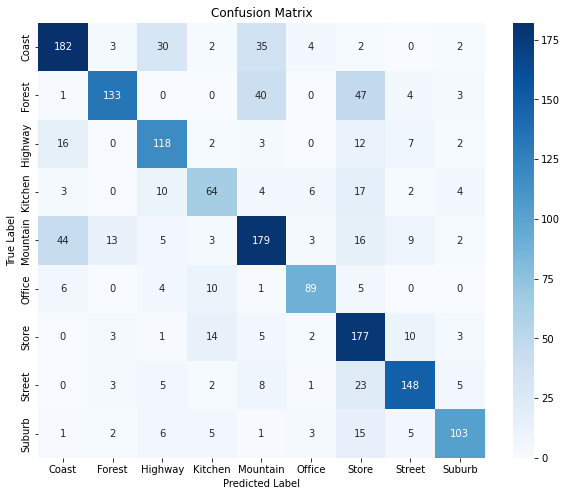

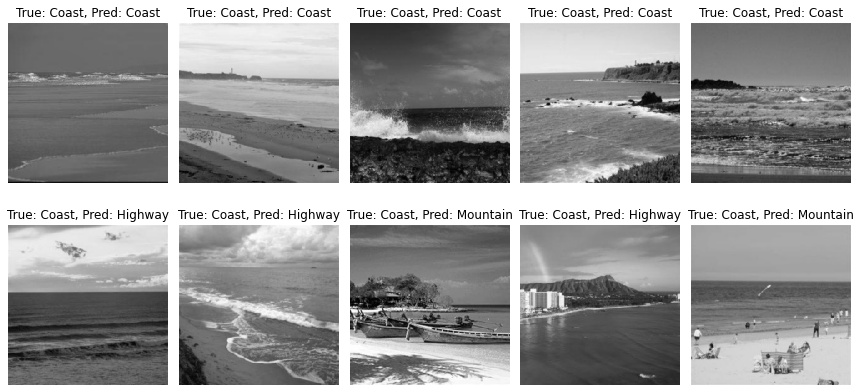

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories and image size
train_dir = 'organized_data/train'
test_dir = 'organized_data/validation'
img_size = 224
batch_size = 64  # Keeping batch size smaller for the dataset size

# Define the image data generators for loading the dataset
# Augment the training set: horizontal flip
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True  # Augmentation: left-right flip
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# VGG16-inspired model with dropout and data augmentation
model = models.Sequential()

# First convolutional stage (2 Conv layers + MaxPooling)
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional stage (2 Conv layers + MaxPooling)
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Third convolutional stage (3 Conv layers + MaxPooling)
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Dropout layer before the final convolutional stage
model.add(layers.Dropout(0.5))  # Adding dropout regularization with 50% dropout rate

# Fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

# Output layer with softmax for 9 categories
model.add(layers.Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

# Evaluate the model on the test set for top-1 accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test top-1 accuracy: {test_acc:.4f}')

# Get predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Top-1 accuracy (already evaluated above as test_acc)
top_1_acc = accuracy_score(y_true, y_pred)
print(f'Top-1 accuracy: {top_1_acc:.4f}')

# Top-3 accuracy
top_3_acc = np.mean([1 if y_true[i] in np.argsort(y_pred_prob[i])[-3:] else 0 for i in range(len(y_true))])
print(f'Top-3 accuracy: {top_3_acc:.4f}')

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Show exactly 5 correct and 5 incorrect classifications
def plot_correct_incorrect_images(images, labels, predictions, class_labels, n=5):
    correct = np.where(predictions == labels)[0]
    incorrect = np.where(predictions != labels)[0]

    # Ensure we don't exceed available correct/incorrect examples
    n_correct = min(n, len(correct))
    n_incorrect = min(n, len(incorrect))

    # Plot n correct predictions
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(np.random.choice(correct, n_correct, replace=False)):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[idx])
        true_label = class_labels[labels[idx]]
        pred_label = class_labels[predictions[idx]]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    # Plot n incorrect predictions
    for i, idx in enumerate(np.random.choice(incorrect, n_incorrect, replace=False)):
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(images[idx])
        true_label = class_labels[labels[idx]]
        pred_label = class_labels[predictions[idx]]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images from the test set to visualize
images, labels_batch = next(test_generator)
labels = np.argmax(labels_batch, axis=1)

# Show 5 correct and 5 incorrect predictions
plot_correct_incorrect_images(images, labels, y_pred[:len(labels)], class_labels)